In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [2]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [3]:
os.chdir('..')
# os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [4]:
from fashion_recommendations.metrics.average_precision import mapk

In [5]:
pd.options.display.max_columns = None

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Load transactions

In [7]:
train_set_orig = pd.read_csv('data/splits/train_subset.tsv', sep='\t', dtype={'article_id': str}, usecols=['t_dat', 'customer_id', 'article_id'])
print(train_set_orig.shape)
train_set_orig.head()

(588758, 3)


,t_dat,customer_id,article_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023
2,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0650193004
3,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0527687006
4,2018-09-20,02bfe1a5248beb9cd28ad4ac630a6d75e78d9a3e14551a...,0668767002


In [8]:
test_set = pd.read_csv('data/splits/test_subset.tsv', sep='\t', dtype={'article_id': str}, usecols=['t_dat', 'customer_id', 'article_id'])
print(test_set.shape)
test_set.head()

(32995, 3)


,t_dat,customer_id,article_id
0,2020-09-15,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007
1,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010
2,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010
3,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0610776105
4,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0929745001


Only include articles bought after 2020-01:

In [9]:
train_set_orig['t_dat'] = pd.to_datetime(train_set_orig['t_dat'])

In [10]:
article_id_to_keep = train_set_orig[train_set_orig['t_dat'] > '2020-08-01']['article_id'].unique()

In [11]:
print(train_set_orig.shape)
train_set_orig = train_set_orig.copy()[train_set_orig['article_id'].isin(article_id_to_keep)]
print(train_set_orig.shape)

(588758, 3)
(202947, 3)


### Load customer features

In [12]:
customers = pd.read_csv('data/customers.csv')
print(customers.shape)
customers.head()

(1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [13]:
customers.isnull().sum() / customers.shape[0]

customer_id               0.000000
FN                        0.652378
Active                    0.661508
club_member_status        0.004418
fashion_news_frequency    0.011669
age                       0.011561
postal_code               0.000000
dtype: float64

In [14]:
customers[['FN', 'Active']] = customers[['FN', 'Active']].fillna(0)

In [15]:
customers['club_member_status'] = customers['club_member_status'].str.lower().str.replace('-', '_').str.replace(' ', '_').fillna('missing')

In [16]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].str.lower().str.replace('-', '_').str.replace(' ', '_').fillna('missing')

In [17]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace('none', 'missing')

In [18]:
customers.isnull().sum()

customer_id                   0
FN                            0
Active                        0
club_member_status            0
fashion_news_frequency        0
age                       15861
postal_code                   0
dtype: int64

`customer_id` to indices

In [19]:
unique_customers_df = test_set[['customer_id']].drop_duplicates().reset_index(drop=True)

customer_id_to_idx = dict(
    zip(
        unique_customers_df['customer_id'],
        unique_customers_df.index
    )
)

len(customer_id_to_idx)

9208

In [24]:
customers_cat_code_to_indices = {}

for cat in ['club_member_status', 'fashion_news_frequency', 'postal_code']:
    customers_cat_code_to_indices[cat] = {v: k for k, v in dict(enumerate(customers[cat].unique())).items()}

In [25]:
for cat in ['club_member_status', 'fashion_news_frequency', 'postal_code']:
    customers[cat] = customers[cat].map(customers_cat_code_to_indices[cat])

In [26]:
customers['customer_id_idx'] = customers['customer_id'].map(customer_id_to_idx)

In [27]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,customer_id_idx
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,0,0,49.0,0,NaN
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,0,0,25.0,1,NaN
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,0,0,24.0,2,0.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,0,0,54.0,3,NaN
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,0,1,52.0,4,NaN


In [28]:
train_set_orig['customer_id_idx'] = train_set_orig['customer_id'].map(customer_id_to_idx)

### Train-dev split

In [29]:
end = train_set_orig['t_dat'].max()
endm1 = end - datetime.timedelta(days=7)

endm1, end

(Timestamp('2020-09-07 00:00:00'), Timestamp('2020-09-14 00:00:00'))

In [30]:
train_set = train_set_orig.copy()[train_set_orig['t_dat'] < endm1]

dev_set = train_set_orig.copy()[train_set_orig['t_dat'] >= endm1]

train_set.drop(columns=['t_dat'], inplace=True)
dev_set.drop(columns=['t_dat'], inplace=True)

train_set.shape, dev_set.shape

((194584, 3), (8363, 3))

### Generate negative samples

In [31]:
train_set.head()

,customer_id,article_id,customer_id_idx
17,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0575347003,3631
43,09bca14258b7e9b9ee968adffe54d45c1e370e8ed79a22...,0579541001,1120
55,183c939bc508ee9c530be249a4e940aace700cdc774e2c...,0615141002,8343
72,1b9496dbe47dd45ffff1630aa2b532d1a5c924c6104d66...,0562245046,2259
77,1b9496dbe47dd45ffff1630aa2b532d1a5c924c6104d66...,0562245001,2259


In [32]:
top_1000 = train_set['article_id'].value_counts().head(1000).index.tolist()
top_1000[:5]

['0706016001', '0706016002', '0372860001', '0610776002', '0759871002']

In [33]:
print(train_set.shape)
train_set = train_set.copy()[train_set['article_id'].isin(top_1000)]
print(train_set.shape)

(194584, 3)
(86369, 3)


In [34]:
print(dev_set.shape)
dev_set = dev_set.copy()[dev_set['article_id'].isin(top_1000)]
print(dev_set.shape)

(8363, 3)
(1218, 3)


In [35]:
train_set_by_customer = train_set.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
print(train_set_by_customer.shape)
train_set_by_customer.head()

(8191, 2)


,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0723529001, 0351484002, 0351484002]"
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0591334019, 0685813001, 0751471001, 070601600..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,[0570002001]
3,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0201219001, 0156231001, 0754751001, 029706700..."
4,004d932f7a27ac3167c77db81d9cfd89392729e7f7e0d4...,"[0573716012, 0573716012, 0571706001, 057371605..."


In [36]:
train_set_by_customer['negative_samples'] = train_set_by_customer.apply(lambda x: list(set(top_1000) - set(x['article_id'])), axis=1)

In [37]:
train_set_by_customer['num_negative_samples'] = train_set_by_customer['negative_samples'].apply(len)

<AxesSubplot:>

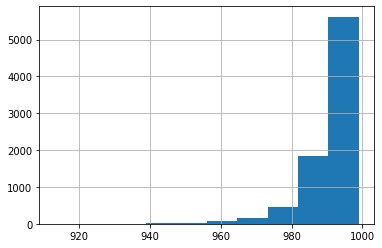

In [38]:
train_set_by_customer['num_negative_samples'].hist()

In [39]:
(train_set_by_customer['num_negative_samples'] == 1000).mean()

0.0

Drop customers with 1000 negative examples, which means they had no positive examples in this set

In [40]:
train_set_by_customer = train_set_by_customer.copy()[train_set_by_customer['num_negative_samples'] != 1000]

In [41]:
train_set_by_customer.head()

,customer_id,article_id,negative_samples,num_negative_samples
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0723529001, 0351484002, 0351484002]","[0732418001, 0598755002, 0610776026, 074606900...",998
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0591334019, 0685813001, 0751471001, 070601600...","[0732418001, 0598755002, 0610776026, 074606900...",989
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,[0570002001],"[0732418001, 0598755002, 0610776026, 074606900...",999
3,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0201219001, 0156231001, 0754751001, 029706700...","[0732418001, 0598755002, 0610776026, 074606900...",990
4,004d932f7a27ac3167c77db81d9cfd89392729e7f7e0d4...,"[0573716012, 0573716012, 0571706001, 057371605...","[0732418001, 0598755002, 0610776026, 074606900...",988


In [42]:
negative_samples_df = train_set_by_customer[['customer_id', 'negative_samples']].explode('negative_samples')
negative_samples_df['purchased'] = 0
negative_samples_df.rename(columns={'negative_samples': 'article_id'}, inplace=True)
print(negative_samples_df.shape)
negative_samples_df.head()

(8123061, 3)


,customer_id,article_id,purchased
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0732418001,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0598755002,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0610776026,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0746069006,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0841260007,0


In [43]:
positive_samples = train_set.copy()
positive_samples['purchased'] = 1
print(positive_samples.shape)
positive_samples.head()

(86369, 4)


,customer_id,article_id,customer_id_idx,purchased
17,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0575347003,3631,1
43,09bca14258b7e9b9ee968adffe54d45c1e370e8ed79a22...,0579541001,1120,1
55,183c939bc508ee9c530be249a4e940aace700cdc774e2c...,0615141002,8343,1
72,1b9496dbe47dd45ffff1630aa2b532d1a5c924c6104d66...,0562245046,2259,1
77,1b9496dbe47dd45ffff1630aa2b532d1a5c924c6104d66...,0562245001,2259,1


In [44]:
train_set = pd.concat([
    positive_samples,
    negative_samples_df
])

train_set = train_set.sample(frac=1, random_state=3)  # shuffle
print(train_set.shape)
train_set.head()

(8209430, 4)


,customer_id,article_id,customer_id_idx,purchased
4887,972ea1ac35f0b0d9ed666e362f617ae79dc8394196b51d...,0749699002,NaN,0
4356,868fb28e62d90449410502a124ba1ed281ed55adeef5aa...,0536139006,NaN,0
1845,37354309974034a40eaa92da3f903a1214d6425bd58221...,0852374004,NaN,0
3115,5fbcfc7218bc6f335f81349f43ab695fe33e93e37017de...,0730683019,NaN,0
7876,f69a59ee1c428f553b64b909e076f90d63a3b5442944c4...,0841383003,NaN,0


In [45]:
train_set['purchased'].mean()

0.010520706066072796

In [46]:
# Check at least 1 positive label per customer
train_set.groupby('customer_id')['purchased'].sum().min() >= 1

True

Dev set prep

In [47]:
dev_set.head()

,customer_id,article_id,customer_id_idx
580405,0214f55e8127a249145342bf9481a6c938d1afedc0d61a...,0536139006,3628
580422,04b52cadd5ae3ddd45ce4d7d851d0a4ac8a10b70e06397...,0557994003,8255
580432,07cc5dd914ff5c829caa6ef179a807dc0b5ba23acb011f...,0896169002,8272
580434,085d2f6d807ca15772cdbbedbf0cb486a461e086e7023e...,0759482001,2155
580435,085d2f6d807ca15772cdbbedbf0cb486a461e086e7023e...,0759482001,2155


In [48]:
# For purposes of dev set only include transactions in top-1000
dev_set['article_id'].isin(top_1000).mean()

1.0

In [49]:
positive_samples_dev = dev_set.copy()[dev_set['article_id'].isin(top_1000)]
positive_samples_dev['purchased'] = 1
print(positive_samples_dev.shape)
positive_samples_dev.head()

(1218, 4)


,customer_id,article_id,customer_id_idx,purchased
580405,0214f55e8127a249145342bf9481a6c938d1afedc0d61a...,0536139006,3628,1
580422,04b52cadd5ae3ddd45ce4d7d851d0a4ac8a10b70e06397...,0557994003,8255,1
580432,07cc5dd914ff5c829caa6ef179a807dc0b5ba23acb011f...,0896169002,8272,1
580434,085d2f6d807ca15772cdbbedbf0cb486a461e086e7023e...,0759482001,2155,1
580435,085d2f6d807ca15772cdbbedbf0cb486a461e086e7023e...,0759482001,2155,1


In [50]:
positive_samples_dev_by_customer = positive_samples_dev.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
print(positive_samples_dev_by_customer.shape)
positive_samples_dev_by_customer.head()

(711, 2)


,customer_id,article_id
0,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,[0448509014]
1,00c14b39b44326040fc0d049d9bcb580a433e86401f7b9...,[0452818001]
2,012b7cc3c5080e46dac622a12e99d23510a4d67a4037d1...,"[0933706001, 0933706001]"
3,012dddef2db56c08e4f993e32ea3a1ff91fedb4fa950d9...,[0655784001]
4,0180d0ef5499cd4dfd920c19821c5f1e3f6692662e7d78...,"[0554450036, 0856440001]"


In [51]:
positive_samples_dev_by_customer['negative_samples'] = positive_samples_dev_by_customer.apply(lambda x: list(set(top_1000) - set(x['article_id'])), axis=1)

In [52]:
negative_samples_df = positive_samples_dev_by_customer[['customer_id', 'negative_samples']].explode('negative_samples')
negative_samples_df['purchased'] = 0
negative_samples_df.rename(columns={'negative_samples': 'article_id'}, inplace=True)
print(negative_samples_df.shape)
negative_samples_df.head()

(709939, 3)


,customer_id,article_id,purchased
0,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0732418001,0
0,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0598755002,0
0,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0610776026,0
0,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0746069006,0
0,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0841260007,0


In [53]:
dev_set = pd.concat([
    positive_samples_dev,
    negative_samples_df
])

dev_set = dev_set.sample(frac=1, random_state=3)  # shuffle
print(dev_set.shape)
dev_set.head()

(711157, 4)


,customer_id,article_id,customer_id_idx,purchased
488,aa47179e404b61a599214735b3d0ee37ad4f936c87731b...,0720125007,NaN,0
100,25e866c8fd9a6bd0f9ffa423946cb0249981bc048482ad...,0848681001,NaN,0
395,87d5f7c850f802c3b5eed35b3d320cbd1c0a065f8faec2...,0470789019,NaN,0
480,a67cfa9a713cf75008a1ab1a30f71aa0e1508bcc726d6c...,0817472001,NaN,0
371,817a4dfd1d0bfca122e17ce92cc7dfef6442940a403e69...,0720504001,NaN,0


In [54]:
dev_set['purchased'].mean()

0.0017127019772005339

`article_id` to indices

In [55]:
articles_df = pd.read_csv(
    'data/articles.csv', 
    dtype={'article_id': str}, 
)
print(articles_df.shape)
articles_df.head()

(105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [56]:
articles_df = articles_df.copy()[articles_df['article_id'].isin(top_1000)]

In [57]:
articles_df['product_group_no'] = articles_df['product_group_name'].copy()

In [58]:
CATEGORICAL_FEATURES = [
    'product_code', 
    'product_type_no', 
    'product_group_no', 
    'graphical_appearance_no', 
    'colour_group_code', 
    'perceived_colour_value_id', 
    'perceived_colour_master_id', 
    'department_no', 
    'index_code', 
    'index_group_no', 
    'section_no', 
    'garment_group_no'
]

In [59]:
cat_code_to_indices = {}

for cat in CATEGORICAL_FEATURES:
    cat_code_to_indices[cat] = {v: k for k, v in dict(enumerate(articles_df[cat].unique())).items()}

In [60]:
for cat in CATEGORICAL_FEATURES:
    articles_df[cat] = articles_df[cat].map(cat_code_to_indices[cat])

In [61]:
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,product_group_no
6,0111565001,0,20 den 1p Stockings,0,Underwear Tights,Socks & Tights,0,Solid,0,Black,0,Dark,0,Black,0,Tights basic,0,Lingeries/Tights,0,Ladieswear,0,"Womens Nightwear, Socks & Tigh",0,Socks and Tights,"Semi shiny nylon stockings with a wide, reinfo...",0
8,0111586001,1,Shape Up 30 den 1p Tights,1,Leggings/Tights,Garment Lower body,0,Solid,0,Black,0,Dark,0,Black,0,Tights basic,0,Lingeries/Tights,0,Ladieswear,0,"Womens Nightwear, Socks & Tigh",0,Socks and Tights,Tights with built-in support to lift the botto...,1
9,0111593001,2,Support 40 den 1p Tights,0,Underwear Tights,Socks & Tights,0,Solid,0,Black,0,Dark,0,Black,0,Tights basic,0,Lingeries/Tights,0,Ladieswear,0,"Womens Nightwear, Socks & Tigh",0,Socks and Tights,"Semi shiny tights that shape the tummy, thighs...",0
23,0120129001,3,Babette long,1,Leggings/Tights,Garment Lower body,0,Solid,0,Black,0,Dark,0,Black,1,Jersey,1,Ladieswear,0,Ladieswear,1,Mama,1,Jersey Fancy,Leggings in soft jersey with a wide panel at t...,1
27,0123173001,4,Control Top 50 den 1p Tights,1,Leggings/Tights,Garment Lower body,0,Solid,0,Black,0,Dark,0,Black,0,Tights basic,0,Lingeries/Tights,0,Ladieswear,0,"Womens Nightwear, Socks & Tigh",0,Socks and Tights,50 denier tights with reinforcement at the top...,1


In [64]:
article_id_to_idx = {v: k for k, v in dict(enumerate(top_1000)).items()}

In [65]:
articles_df['article_id_idx'] = articles_df['article_id'].map(article_id_to_idx)

In [66]:
train_set['article_id_idx'] = train_set['article_id'].map(article_id_to_idx)
dev_set['article_id_idx'] = dev_set['article_id'].map(article_id_to_idx)

In [67]:
train_set.head()

,customer_id,article_id,customer_id_idx,purchased,article_id_idx
4887,972ea1ac35f0b0d9ed666e362f617ae79dc8394196b51d...,0749699002,NaN,0,56
4356,868fb28e62d90449410502a124ba1ed281ed55adeef5aa...,0536139006,NaN,0,73
1845,37354309974034a40eaa92da3f903a1214d6425bd58221...,0852374004,NaN,0,685
3115,5fbcfc7218bc6f335f81349f43ab695fe33e93e37017de...,0730683019,NaN,0,434
7876,f69a59ee1c428f553b64b909e076f90d63a3b5442944c4...,0841383003,NaN,0,90


In [68]:
dev_set.head()

,customer_id,article_id,customer_id_idx,purchased,article_id_idx
488,aa47179e404b61a599214735b3d0ee37ad4f936c87731b...,0720125007,NaN,0,172
100,25e866c8fd9a6bd0f9ffa423946cb0249981bc048482ad...,0848681001,NaN,0,984
395,87d5f7c850f802c3b5eed35b3d320cbd1c0a065f8faec2...,0470789019,NaN,0,207
480,a67cfa9a713cf75008a1ab1a30f71aa0e1508bcc726d6c...,0817472001,NaN,0,737
371,817a4dfd1d0bfca122e17ce92cc7dfef6442940a403e69...,0720504001,NaN,0,470


In [69]:
train_set['customer_id_idx'] = train_set['customer_id'].map(customer_id_to_idx)
dev_set['customer_id_idx'] = dev_set['customer_id'].map(customer_id_to_idx)

In [70]:
train_set['customer_id_idx'].isnull().sum() + dev_set['customer_id_idx'].isnull().sum()

0

In [71]:
train_set['article_id_idx'].isnull().sum() + dev_set['article_id_idx'].isnull().sum()

0

### Merge features

In [72]:
train_set = (
    train_set[['purchased', 'customer_id_idx', 'article_id_idx']]
    .merge(customers, on='customer_id_idx', how='left')
    .merge(articles_df, on='article_id_idx', how='left')
)
print(train_set.shape)
train_set.head()

(8209430, 36)


,purchased,customer_id_idx,article_id_idx,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,product_group_no
0,0,8818,56,972ea1ac35f0b0d9ed666e362f617ae79dc8394196b51d...,1.0,1.0,0,1,64.0,284476,0749699002,307,Chestnut strap top,18,Vest top,Garment Upper body,0,Solid,19,Off White,1,Dusty Light,2,White,29,Jersey,1,Ladieswear,0,Ladieswear,17,Womens Tailoring,1,Jersey Fancy,Top in viscose jersey with a V-neck front and ...,5
1,0,4314,73,868fb28e62d90449410502a124ba1ed281ed55adeef5aa...,1.0,1.0,0,1,20.0,263031,0536139006,84,Alex Jogger (J),26,Pyjama bottom,Nightwear,0,Solid,0,Black,0,Dark,0,Black,28,Nightwear,0,Lingeries/Tights,0,Ladieswear,0,"Womens Nightwear, Socks & Tigh",2,"Under-, Nightwear",Pyjama bottoms in lightweight fabric with an e...,9
2,0,6505,685,37354309974034a40eaa92da3f903a1214d6425bd58221...,0.0,0.0,0,0,20.0,86802,0852374004,553,Berry,7,Dress,Garment Full body,3,All over pattern,0,Black,0,Dark,0,Black,71,Dress,1,Ladieswear,0,Ladieswear,13,Womens Everyday Collection,10,Dresses Ladies,Calf-length dress in an airy viscose weave. Ro...,4
3,0,1468,434,5fbcfc7218bc6f335f81349f43ab695fe33e93e37017de...,0.0,0.0,0,0,30.0,80018,0730683019,260,HAVANA HW tights,1,Leggings/Tights,Garment Lower body,6,Placement print,0,Black,0,Dark,0,Black,23,Ladies Sport Bottoms,5,Sport,3,Sport,16,Ladies H&M Sport,1,Jersey Fancy,Sports tights in fast-drying functional fabric...,1
4,0,2064,90,f69a59ee1c428f553b64b909e076f90d63a3b5442944c4...,0.0,0.0,0,0,23.0,213524,0841383003,526,Vanessa 2-pack,18,Vest top,Garment Upper body,0,Solid,2,White,2,Light,2,White,4,Jersey Basic,1,Ladieswear,0,Ladieswear,3,Womens Everyday Basics,3,Jersey Basic,Fitted strappy top in soft organic cotton jersey.,5


In [73]:
dev_set = (
    dev_set[['purchased', 'customer_id_idx', 'article_id_idx']]
    .merge(customers, on='customer_id_idx', how='left')
    .merge(articles_df, on='article_id_idx', how='left')
)
print(dev_set.shape)
dev_set.head()

(711157, 36)


,purchased,customer_id_idx,article_id_idx,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,product_group_no
0,0,4512,172,aa47179e404b61a599214735b3d0ee37ad4f936c87731b...,0.0,0.0,0,0,25.0,84945,0720125007,244,SUPREME RW tights,1,Leggings/Tights,Garment Lower body,1,Melange,0,Black,0,Dark,0,Black,23,Ladies Sport Bottoms,5,Sport,3,Sport,16,Ladies H&M Sport,1,Jersey Fancy,Sports tights in fast-drying functional fabric...,1
1,0,5173,984,25e866c8fd9a6bd0f9ffa423946cb0249981bc048482ad...,1.0,1.0,0,1,58.0,91797,0848681001,544,Barton Midi Skirt new,6,Skirt,Garment Lower body,0,Solid,0,Black,0,Dark,0,Black,78,Projects Woven Bottoms,3,Divided,1,Divided,25,Divided Projects,9,Trousers,"Calf-length, pleated skirt in an airy weave. H...",1
2,0,4321,207,87d5f7c850f802c3b5eed35b3d320cbd1c0a065f8faec2...,1.0,1.0,0,1,31.0,62773,0470789019,64,OP Brazilian 2p Low (Acacia),8,Underwear bottom,Underwear,0,Solid,1,Light Beige,1,Dusty Light,1,Beige,2,Clean Lingerie,0,Lingeries/Tights,0,Ladieswear,2,Womens Lingerie,2,"Under-, Nightwear",Microfibre Brazilian briefs with laser-cut edg...,2
3,0,706,737,a67cfa9a713cf75008a1ab1a30f71aa0e1508bcc726d6c...,1.0,1.0,0,1,50.0,35736,0817472001,455,Kelso,15,Shorts,Garment Lower body,0,Solid,0,Black,0,Dark,0,Black,41,Shorts,1,Ladieswear,0,Ladieswear,13,Womens Everyday Collection,14,Shorts,Shorts in a softly draping viscose weave. High...,1
4,0,7754,470,817a4dfd1d0bfca122e17ce92cc7dfef6442940a403e69...,0.0,0.0,0,0,25.0,52219,0720504001,245,Skinny 5pkt Lowprice,17,Trousers,Garment Lower body,4,Denim,0,Black,0,Dark,0,Black,45,Denim trousers,4,Menswear,2,Menswear,19,Denim Men,5,Trousers Denim,5-pocket jeans in washed stretch denim with a ...,1


### Impute `NULL`s

In [74]:
train_set.isnull().sum()[train_set.isnull().sum() > 0]

age            28040
detail_desc    16414
dtype: int64

In [75]:
dev_set.isnull().sum()[dev_set.isnull().sum() > 0]

age            4000
detail_desc    1423
dtype: int64

In [76]:
from sklearn.impute import SimpleImputer

In [77]:
age_imputer = SimpleImputer()

In [78]:
age_imputer.fit(train_set['age'].values.reshape(-1, 1))

SimpleImputer()

In [79]:
train_set['age'] = age_imputer.transform(train_set['age'].values.reshape(-1, 1))

In [80]:
dev_set['age'] = age_imputer.transform(dev_set['age'].values.reshape(-1, 1))

In [81]:
train_set.head()

,purchased,customer_id_idx,article_id_idx,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,product_group_no
0,0,8818,56,972ea1ac35f0b0d9ed666e362f617ae79dc8394196b51d...,1.0,1.0,0,1,64.0,284476,0749699002,307,Chestnut strap top,18,Vest top,Garment Upper body,0,Solid,19,Off White,1,Dusty Light,2,White,29,Jersey,1,Ladieswear,0,Ladieswear,17,Womens Tailoring,1,Jersey Fancy,Top in viscose jersey with a V-neck front and ...,5
1,0,4314,73,868fb28e62d90449410502a124ba1ed281ed55adeef5aa...,1.0,1.0,0,1,20.0,263031,0536139006,84,Alex Jogger (J),26,Pyjama bottom,Nightwear,0,Solid,0,Black,0,Dark,0,Black,28,Nightwear,0,Lingeries/Tights,0,Ladieswear,0,"Womens Nightwear, Socks & Tigh",2,"Under-, Nightwear",Pyjama bottoms in lightweight fabric with an e...,9
2,0,6505,685,37354309974034a40eaa92da3f903a1214d6425bd58221...,0.0,0.0,0,0,20.0,86802,0852374004,553,Berry,7,Dress,Garment Full body,3,All over pattern,0,Black,0,Dark,0,Black,71,Dress,1,Ladieswear,0,Ladieswear,13,Womens Everyday Collection,10,Dresses Ladies,Calf-length dress in an airy viscose weave. Ro...,4
3,0,1468,434,5fbcfc7218bc6f335f81349f43ab695fe33e93e37017de...,0.0,0.0,0,0,30.0,80018,0730683019,260,HAVANA HW tights,1,Leggings/Tights,Garment Lower body,6,Placement print,0,Black,0,Dark,0,Black,23,Ladies Sport Bottoms,5,Sport,3,Sport,16,Ladies H&M Sport,1,Jersey Fancy,Sports tights in fast-drying functional fabric...,1
4,0,2064,90,f69a59ee1c428f553b64b909e076f90d63a3b5442944c4...,0.0,0.0,0,0,23.0,213524,0841383003,526,Vanessa 2-pack,18,Vest top,Garment Upper body,0,Solid,2,White,2,Light,2,White,4,Jersey Basic,1,Ladieswear,0,Ladieswear,3,Womens Everyday Basics,3,Jersey Basic,Fitted strappy top in soft organic cotton jersey.,5


### Train model

In [82]:
NUMERIC_FEATURES = [
    'FN', 
    'Active', 
    'age'
]

In [84]:
# train_set[[
#     'customer_id_idx',
#     'article_id_idx',
#     'product_code',
#     'product_type_no',
#     'graphical_appearance_no',
#     'perceived_colour_value_id',
#     'perceived_colour_master_id',
#     'department_no',
#     'index_code',
#     'index_group_no',
#     'section_no',
#     'garment_group_no',
#     'club_member_status',
#     'fashion_news_frequency',
#     'postal_code',
#     'purchased'] +
#     NUMERIC_FEATURES
# ]

In [85]:
class PurchasesDatasetWithArticleFeatures(Dataset):

    def __init__(self, df):
        self.customer_id_idx = df['customer_id_idx'].values
        self.article_id_idx = df['article_id_idx'].values
        self.product_code = df['product_code'].values
        self.product_type_no = df['product_type_no'].values
        self.product_group_no = df['product_group_no'].values
        self.graphical_appearance_no = df['graphical_appearance_no'].values
        self.colour_group_code = df['colour_group_code'].values
        self.perceived_colour_value_id = df['perceived_colour_value_id'].values
        self.perceived_colour_master_id = df['perceived_colour_master_id'].values
        self.department_no = df['department_no'].values
        self.index_code = df['index_code'].values
        self.index_group_no = df['index_group_no'].values
        self.section_no = df['section_no'].values
        self.garment_group_no = df['garment_group_no'].values
        
        self.club_member_status = df['club_member_status'].values
        self.fashion_news_frequency = df['fashion_news_frequency'].values
        self.postal_code = df['postal_code'].values
        self.numeric_features = df[NUMERIC_FEATURES].values
        
        self.purchased = df['purchased'].values

    def __len__(self):
        return self.customer_id_idx.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return (
            self.customer_id_idx[idx],
            self.article_id_idx[idx],
            self.product_code[idx],
            self.product_type_no[idx],
            self.product_group_no[idx],
            self.graphical_appearance_no[idx],
            self.colour_group_code[idx],
            self.perceived_colour_value_id[idx],
            self.perceived_colour_master_id[idx],
            self.department_no[idx],
            self.index_code[idx],
            self.index_group_no[idx],
            self.section_no[idx],
            self.garment_group_no[idx],
            self.club_member_status[idx],
            self.fashion_news_frequency[idx],
            self.postal_code[idx],
            self.numeric_features[idx],
            self.purchased[idx]
        )

In [86]:
train_dataset = PurchasesDatasetWithArticleFeatures(train_set)
dev_dataset = PurchasesDatasetWithArticleFeatures(dev_set)

In [87]:
BATCH_SIZE = 2048

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)  

In [88]:
# # Selecting a subset of data
# subset = torch.utils.data.Subset(train_dataset, [1])

# train_loader = DataLoader(subset, batch_size=BATCH_SIZE)  

In [89]:
class FashionRecV2(nn.Module):

    def __init__(self, embedding_dim):
        super(FashionRecV2, self).__init__()
        
        # Embeddings
        self.user_embeddings = nn.Embedding(num_embeddings=len(customer_id_to_idx), embedding_dim=embedding_dim)        
        self.item_embeddings = nn.Embedding(num_embeddings=len(article_id_to_idx), embedding_dim=embedding_dim)
        self.product_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_code']), embedding_dim=embedding_dim)
        self.product_type_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_type_no']), embedding_dim=embedding_dim)
        self.product_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_group_no']), embedding_dim=embedding_dim)
        self.graphical_appearance_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['graphical_appearance_no']), embedding_dim=embedding_dim)
        self.colour_group_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['colour_group_code']), embedding_dim=embedding_dim)
        self.perceived_colour_value_id_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['perceived_colour_value_id']), embedding_dim=embedding_dim)
        self.perceived_colour_master_id_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['perceived_colour_master_id']), embedding_dim=embedding_dim)
        self.department_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['department_no']), embedding_dim=embedding_dim)
        self.index_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['index_code']), embedding_dim=embedding_dim)
        self.index_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['index_group_no']), embedding_dim=embedding_dim)
        self.section_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['section_no']), embedding_dim=embedding_dim)
        self.garment_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['garment_group_no']), embedding_dim=embedding_dim)
        
        self.club_member_status_embeddings = nn.Embedding(num_embeddings=len(customers_cat_code_to_indices['club_member_status']), embedding_dim=embedding_dim)
        self.fashion_news_frequency_embeddings = nn.Embedding(num_embeddings=len(customers_cat_code_to_indices['fashion_news_frequency']), embedding_dim=embedding_dim)
        self.postal_code_embeddings = nn.Embedding(num_embeddings=len(customers_cat_code_to_indices['postal_code']), embedding_dim=embedding_dim)

        # Initialise embeddings
        torch.nn.init.xavier_uniform_(self.user_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.item_embeddings.weight)        
        torch.nn.init.xavier_uniform_(self.product_code_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.product_type_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.product_group_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.graphical_appearance_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.colour_group_code_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.perceived_colour_value_id_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.perceived_colour_master_id_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.department_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.index_code_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.index_group_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.section_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.garment_group_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.club_member_status_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.fashion_news_frequency_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.postal_code_embeddings.weight)
        
        # FC layers
        self.fc_1 = nn.Linear(in_features=embedding_dim*17+len(NUMERIC_FEATURES), out_features=500)            
        self.fc_2 = nn.Linear(in_features=500, out_features=250)
        # self.fc_3 = nn.Linear(in_features=500, out_features=250)        
        self.fc_3 = nn.Linear(in_features=250, out_features=1)
        
        # Activation functions
        self.relu = nn.ReLU()        
        self.sigmoid = nn.Sigmoid()
        
        # Dropout
        self.dropout = nn.Dropout(0.2)
        
    def forward(
        self, 
        user_id, 
        item_id,
        product_code, 
        product_type_no, 
        product_group_no, 
        graphical_appearance_no, 
        colour_group_code, 
        perceived_colour_value_id, 
        perceived_colour_master_id, 
        department_no, 
        index_code, 
        index_group_no, 
        section_no, 
        garment_group_no,
        club_member_status,
        fashion_news_frequency,
        postal_code,
        numeric_features,
    ):

        user_emb = self.user_embeddings(user_id)
        item_emb = self.item_embeddings(item_id)
        product_code_emb = self.product_code_embeddings(product_code)
        product_type_no_emb = self.product_type_no_embeddings(product_type_no)
        product_group_no_emb = self.product_group_no_embeddings(product_group_no)
        graphical_appearance_no_emb = self.graphical_appearance_no_embeddings(graphical_appearance_no)
        colour_group_code_emb = self.colour_group_code_embeddings(colour_group_code)
        perceived_colour_value_id_emb = self.perceived_colour_value_id_embeddings(perceived_colour_value_id)
        perceived_colour_master_id_emb = self.perceived_colour_master_id_embeddings(perceived_colour_master_id)
        department_no_emb = self.department_no_embeddings(department_no)
        index_code_emb = self.index_code_embeddings(index_code)
        index_group_no_emb = self.index_group_no_embeddings(index_group_no)
        section_no_emb = self.section_no_embeddings(section_no)
        garment_group_no_emb = self.garment_group_no_embeddings(garment_group_no)
        
        club_member_status_emb = self.club_member_status_embeddings(club_member_status)
        fashion_news_frequency_emb = self.fashion_news_frequency_embeddings(fashion_news_frequency)
        postal_code_emb = self.postal_code_embeddings(postal_code)
              
        concatenated_emb = torch.concat(
            [
                user_emb, 
                item_emb,
                product_code_emb,
                product_type_no_emb,
                product_group_no_emb,
                graphical_appearance_no_emb,
                colour_group_code_emb,
                perceived_colour_value_id_emb,
                perceived_colour_master_id_emb,
                department_no_emb,
                index_code_emb,
                index_group_no_emb,
                section_no_emb,
                garment_group_no_emb,
                club_member_status_emb,
                fashion_news_frequency_emb,
                postal_code_emb,
                numeric_features
            ], 
            dim=1
        )
        
        x = self.fc_1(concatenated_emb)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_3(x)
        x = self.sigmoid(x)

        return x

In [90]:
fashion_rec_v2 = FashionRecV2(embedding_dim=32)

In [91]:
fashion_rec_v2.to(device)

FashionRecV2(
  (user_embeddings): Embedding(9208, 32)
  (item_embeddings): Embedding(1000, 32)
  (product_code_embeddings): Embedding(627, 32)
  (product_type_no_embeddings): Embedding(48, 32)
  (product_group_no_embeddings): Embedding(10, 32)
  (graphical_appearance_no_embeddings): Embedding(20, 32)
  (colour_group_code_embeddings): Embedding(36, 32)
  (perceived_colour_value_id_embeddings): Embedding(6, 32)
  (perceived_colour_master_id_embeddings): Embedding(16, 32)
  (department_no_embeddings): Embedding(80, 32)
  (index_code_embeddings): Embedding(6, 32)
  (index_group_no_embeddings): Embedding(4, 32)
  (section_no_embeddings): Embedding(26, 32)
  (garment_group_no_embeddings): Embedding(19, 32)
  (club_member_status_embeddings): Embedding(4, 32)
  (fashion_news_frequency_embeddings): Embedding(3, 32)
  (postal_code_embeddings): Embedding(352899, 32)
  (fc_1): Linear(in_features=547, out_features=500, bias=True)
  (fc_2): Linear(in_features=500, out_features=250, bias=True)
  (fc

In [92]:
# fashion_rec_v2(torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), )

In [93]:
optimizer = torch.optim.Adam(params=fashion_rec_v2.parameters(), lr=0.0001)

Switched to BCELoss instead of weighted MSE. Had more success with this.

In [94]:
criterion = nn.BCELoss()

In [96]:
MAX_EPOCHS = 7
training_losses = []
dev_losses = []

for epoch in range(MAX_EPOCHS):
    
    for data in tqdm(train_loader):
        
        user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data    
        
        user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
            user_id.to(device), 
            item_id.to(device), 
            product_code.to(device), 
            product_type_no.to(device), 
            product_group_no.to(device), 
            graphical_appearance_no.to(device), 
            colour_group_code.to(device), 
            perceived_colour_value_id.to(device), 
            perceived_colour_master_id.to(device), 
            department_no.to(device), 
            index_code.to(device), 
            index_group_no.to(device), 
            section_no.to(device), 
            garment_group_no.to(device), 
            club_member_status.to(device), 
            fashion_news_frequency.to(device), 
            postal_code.to(device), 
            numeric_features.to(device),
            label.to(device)
        )    

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        pred = fashion_rec_v2(
            user_id, 
            item_id, 
            product_code, 
            product_type_no, 
            product_group_no, 
            graphical_appearance_no, 
            colour_group_code, 
            perceived_colour_value_id, 
            perceived_colour_master_id, 
            department_no, 
            index_code, 
            index_group_no, 
            section_no, 
            garment_group_no,
            club_member_status,
            fashion_news_frequency,
            postal_code,
            numeric_features.float()
        )

        loss = criterion(pred.flatten(), label.float())

        loss.backward()  
        
        optimizer.step()
        
    # Compute training loss
    
    total_train_loss = 0

    fashion_rec_v2.eval()

    with torch.no_grad():
        for data in tqdm(DataLoader(train_dataset, batch_size=BATCH_SIZE*4)):
            
            user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data

            user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
                user_id.to(device), 
                item_id.to(device), 
                product_code.to(device), 
                product_type_no.to(device), 
                product_group_no.to(device), 
                graphical_appearance_no.to(device), 
                colour_group_code.to(device), 
                perceived_colour_value_id.to(device), 
                perceived_colour_master_id.to(device), 
                department_no.to(device), 
                index_code.to(device), 
                index_group_no.to(device), 
                section_no.to(device), 
                garment_group_no.to(device), 
                club_member_status.to(device), 
                fashion_news_frequency.to(device), 
                postal_code.to(device), 
                numeric_features.to(device),
                label.to(device)
            )

            pred = fashion_rec_v2(
                user_id, 
                item_id, 
                product_code, 
                product_type_no, 
                product_group_no, 
                graphical_appearance_no, 
                colour_group_code, 
                perceived_colour_value_id, 
                perceived_colour_master_id, 
                department_no, 
                index_code, 
                index_group_no, 
                section_no, 
                garment_group_no,
                club_member_status,
                fashion_news_frequency,
                postal_code,
                numeric_features.float()
            )

            loss = nn.BCELoss(reduction='sum')(pred.flatten(), label.float())

            total_train_loss += loss.item()

        mean_train_loss = total_train_loss / len(train_dataset)

        print(f"Training loss: {mean_train_loss}")
        training_losses.append(mean_train_loss)
    
    # Compute dev loss
    
    total_dev_loss = 0

    with torch.no_grad():
        for data in tqdm(DataLoader(dev_dataset, batch_size=BATCH_SIZE*4)):
            
            user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data                    
        
            user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
                user_id.to(device), 
                item_id.to(device), 
                product_code.to(device), 
                product_type_no.to(device), 
                product_group_no.to(device), 
                graphical_appearance_no.to(device), 
                colour_group_code.to(device), 
                perceived_colour_value_id.to(device), 
                perceived_colour_master_id.to(device), 
                department_no.to(device), 
                index_code.to(device), 
                index_group_no.to(device), 
                section_no.to(device), 
                garment_group_no.to(device), 
                club_member_status.to(device), 
                fashion_news_frequency.to(device), 
                postal_code.to(device), 
                numeric_features.to(device),
                label.to(device)
            )    

            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            pred = fashion_rec_v2(
                user_id, 
                item_id, 
                product_code, 
                product_type_no, 
                product_group_no, 
                graphical_appearance_no, 
                colour_group_code, 
                perceived_colour_value_id, 
                perceived_colour_master_id, 
                department_no, 
                index_code, 
                index_group_no, 
                section_no, 
                garment_group_no,
                club_member_status,
                fashion_news_frequency,
                postal_code,
                numeric_features.float()
            )

            loss = nn.BCELoss(reduction='sum')(pred.flatten(), label.float())

            total_dev_loss += loss.item()

        mean_dev_loss = total_dev_loss / len(dev_dataset)

        print(f"Dev loss: {mean_dev_loss}")
        dev_losses.append(mean_dev_loss)
    
    fashion_rec_v2.train()

  1%|█▎                                                                                                                                                                                                  | 28/4009 [00:06<15:05,  4.40it/s]


KeyboardInterrupt: 

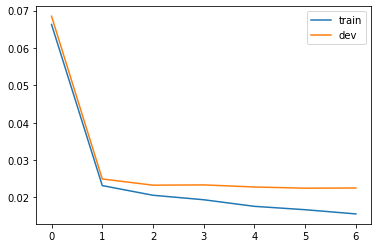

In [110]:
plt.plot(training_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()
plt.show()

Based on https://stackoverflow.com/questions/64294962/how-to-implement-learning-to-rank-using-lightgbm

In [68]:
import re

In [69]:
train_set.columns = [re.sub(r'[^\w\s]','',s).replace(' ', '') for s in train_set.columns]
dev_set.columns = [re.sub(r'[^\w\s]','',s).replace(' ', '') for s in dev_set.columns]

In [70]:
train_set.sort_values('customer_id', inplace=True)
train_set.head()

,customer_id,article_id,purchased,age,FN_10,Active_10,club_member_status_active,club_member_status_left_club,club_member_status_missing,club_member_status_pre_create,fashion_news_frequency_missing,fashion_news_frequency_monthly,fashion_news_frequency_regularly,perceived_colour_value_name_Bright,perceived_colour_value_name_Dark,perceived_colour_value_name_DustyLight,perceived_colour_value_name_Light,perceived_colour_value_name_Medium,perceived_colour_value_name_MediumDusty,perceived_colour_value_name_Undefined,perceived_colour_value_name_Unknown,index_name_BabySizes5098,index_name_ChildrenAccessoriesSwimwear,index_name_ChildrenSizes134170,index_name_ChildrenSizes92140,index_name_Divided,index_name_LadiesAccessories,index_name_Ladieswear,index_name_LingeriesTights,index_name_Menswear,index_name_Sport,index_group_name_BabyChildren,index_group_name_Divided,index_group_name_Ladieswear,index_group_name_Menswear,index_group_name_Sport
3684530,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0506098007,0,24.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4579577,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0562245102,0,24.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1300398,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0829302001,0,24.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1198544,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0739144004,0,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
5092295,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0399136004,0,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [71]:
dev_set.sort_values('customer_id', inplace=True)
dev_set.head()

,customer_id,article_id,purchased,age,FN_10,Active_10,club_member_status_active,club_member_status_left_club,club_member_status_missing,club_member_status_pre_create,fashion_news_frequency_missing,fashion_news_frequency_monthly,fashion_news_frequency_regularly,perceived_colour_value_name_Bright,perceived_colour_value_name_Dark,perceived_colour_value_name_DustyLight,perceived_colour_value_name_Light,perceived_colour_value_name_Medium,perceived_colour_value_name_MediumDusty,perceived_colour_value_name_Undefined,perceived_colour_value_name_Unknown,index_name_BabySizes5098,index_name_ChildrenAccessoriesSwimwear,index_name_ChildrenSizes134170,index_name_ChildrenSizes92140,index_name_Divided,index_name_LadiesAccessories,index_name_Ladieswear,index_name_LingeriesTights,index_name_Menswear,index_name_Sport,index_group_name_BabyChildren,index_group_name_Divided,index_group_name_Ladieswear,index_group_name_Menswear,index_group_name_Sport
192612,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0189626001,0,38.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
659707,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0557599022,0,38.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
467168,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0519583008,0,38.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
485863,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0811783002,0,38.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
610426,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,0759479001,0,38.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [72]:
qids_train = train_set.groupby("customer_id")["customer_id"].count().to_numpy()
X_train = train_set.drop(["customer_id", "article_id", "purchased"], axis=1)
y_train = train_set["purchased"]

qids_dev = dev_set.groupby("customer_id")["customer_id"].count().to_numpy()
X_dev = dev_set.drop(["customer_id", "article_id", "purchased"], axis=1)
y_dev = dev_set["purchased"]

In [73]:
import lightgbm

In [110]:
model = lightgbm.LGBMRanker(
    objective="lambdarank",
    metric=["map", "ndcg"],
    max_depth=2,
    n_estimators=20,
    random_state=3
)

In [111]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 20,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'lambdarank',
 'random_state': 3,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': ['map', 'ndcg']}

In [112]:
%%time
model.fit(
    X=X_train,
    y=y_train,
    group=qids_train,
    eval_set=[(X_dev, y_dev)],
    eval_group=[qids_dev],
    eval_at=12,
    verbose=10,
)

/Users/stevengeorge/opt/anaconda3/envs/fashion_rec/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's map@12: 0.00300717	valid_0's ndcg@12: 0.00424247
[20]	valid_0's map@12: 0.00584792	valid_0's ndcg@12: 0.0082172
CPU times: user 57 s, sys: 3.61 s, total: 1min
Wall time: 10.8 s


LGBMRanker(max_depth=2, metric=['map', 'ndcg'], n_estimators=20,
           objective='lambdarank', random_state=3)

In [113]:
predictions_dev = model.predict(X_dev)

In [114]:
dev_set['predictions'] = predictions_dev

In [115]:
predictions_list = (
    dev_set
    .sort_values(['customer_id', 'predictions'], ascending=False)
    .groupby('customer_id').head(12)
    .groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
)
predictions_list.head()

,customer_id,article_id
0,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,"[0743098001, 0918292011, 0818031003, 085025900..."
1,00c14b39b44326040fc0d049d9bcb580a433e86401f7b9...,"[0743098001, 0918292011, 0817361007, 081803100..."
2,012b7cc3c5080e46dac622a12e99d23510a4d67a4037d1...,"[0743098001, 0918292011, 0850259002, 084337300..."
3,012dddef2db56c08e4f993e32ea3a1ff91fedb4fa950d9...,"[0743098001, 0918292011, 0818031003, 084337300..."
4,0180d0ef5499cd4dfd920c19821c5f1e3f6692662e7d78...,"[0743098001, 0918292011, 0817361007, 085025900..."


In [116]:
actuals_list = dev_set[dev_set['purchased'] == 1].groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
actuals_list.head()

,customer_id,article_id
0,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,[0448509014]
1,00c14b39b44326040fc0d049d9bcb580a433e86401f7b9...,[0452818001]
2,012b7cc3c5080e46dac622a12e99d23510a4d67a4037d1...,"[0933706001, 0933706001]"
3,012dddef2db56c08e4f993e32ea3a1ff91fedb4fa950d9...,[0655784001]
4,0180d0ef5499cd4dfd920c19821c5f1e3f6692662e7d78...,"[0856440001, 0554450036]"


In [117]:
predictions_list.shape, actuals_list.shape

((711, 2), (711, 2))

In [118]:
predictions_df = predictions_list.merge(actuals_list, on='customer_id', suffixes=('_pred', '_act'))
predictions_df.head()

,customer_id,article_id_pred,article_id_act
0,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,"[0743098001, 0918292011, 0818031003, 085025900...",[0448509014]
1,00c14b39b44326040fc0d049d9bcb580a433e86401f7b9...,"[0743098001, 0918292011, 0817361007, 081803100...",[0452818001]
2,012b7cc3c5080e46dac622a12e99d23510a4d67a4037d1...,"[0743098001, 0918292011, 0850259002, 084337300...","[0933706001, 0933706001]"
3,012dddef2db56c08e4f993e32ea3a1ff91fedb4fa950d9...,"[0743098001, 0918292011, 0818031003, 084337300...",[0655784001]
4,0180d0ef5499cd4dfd920c19821c5f1e3f6692662e7d78...,"[0743098001, 0918292011, 0817361007, 085025900...","[0856440001, 0554450036]"


In [119]:
mapk(predictions_df['article_id_act'], predictions_df['article_id_pred'], k=12)

0.005613507318851904

### Test set evaluation

In [120]:
test_actuals = test_set.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
test_actuals.head()

,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[0794321007]
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0778745010, 0778745010, 0610776105, 092974500..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0855249006, 0822171001]"
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0920012003, 0572797002, 0572797002, 056860104..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0827968001, 0887757001, 0673677002, 079936500..."


In [121]:
test_customers = test_actuals[['customer_id']]
test_customers['join_key'] = 1

In [122]:
len(top_1000)

1000

In [123]:
top_k_articles_df = pd.DataFrame(top_1000, columns=['article_id'])
top_k_articles_df['join_key'] = 1

In [124]:
test_customers = test_customers.merge(top_k_articles_df, on='join_key').drop(columns='join_key')
print(test_customers.shape)
test_customers.head()

(9208000, 2)


,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016002
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0372860001
3,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0610776002
4,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0759871002


In [125]:
test_customers = (
    test_customers
    .merge(customers, on='customer_id', how='left')
    .merge(articles_df, on='article_id', how='left')
)
print(test_customers.shape)
test_customers.head()

(9208000, 35)


,customer_id,article_id,age,FN_1.0,Active_1.0,club_member_status_active,club_member_status_left_club,club_member_status_missing,club_member_status_pre_create,fashion_news_frequency_missing,fashion_news_frequency_monthly,fashion_news_frequency_regularly,perceived_colour_value_name_Bright,perceived_colour_value_name_Dark,perceived_colour_value_name_Dusty Light,perceived_colour_value_name_Light,perceived_colour_value_name_Medium,perceived_colour_value_name_Medium Dusty,perceived_colour_value_name_Undefined,perceived_colour_value_name_Unknown,index_name_Baby Sizes 50-98,"index_name_Children Accessories, Swimwear",index_name_Children Sizes 134-170,index_name_Children Sizes 92-140,index_name_Divided,index_name_Ladies Accessories,index_name_Ladieswear,index_name_Lingeries/Tights,index_name_Menswear,index_name_Sport,index_group_name_Baby/Children,index_group_name_Divided,index_group_name_Ladieswear,index_group_name_Menswear,index_group_name_Sport
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016002,24.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0372860001,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0610776002,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0759871002,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [126]:
test_customers['age'] = age_imputer.transform(test_customers['age'].values.reshape(-1, 1))

In [127]:
test_predictions = model.predict(
    test_customers.drop(["customer_id", "article_id"], axis=1)
)

In [128]:
test_customers['predictions'] = test_predictions

In [129]:
test_customers.head()

,customer_id,article_id,age,FN_1.0,Active_1.0,club_member_status_active,club_member_status_left_club,club_member_status_missing,club_member_status_pre_create,fashion_news_frequency_missing,fashion_news_frequency_monthly,fashion_news_frequency_regularly,perceived_colour_value_name_Bright,perceived_colour_value_name_Dark,perceived_colour_value_name_Dusty Light,perceived_colour_value_name_Light,perceived_colour_value_name_Medium,perceived_colour_value_name_Medium Dusty,perceived_colour_value_name_Undefined,perceived_colour_value_name_Unknown,index_name_Baby Sizes 50-98,"index_name_Children Accessories, Swimwear",index_name_Children Sizes 134-170,index_name_Children Sizes 92-140,index_name_Divided,index_name_Ladies Accessories,index_name_Ladieswear,index_name_Lingeries/Tights,index_name_Menswear,index_name_Sport,index_group_name_Baby/Children,index_group_name_Divided,index_group_name_Ladieswear,index_group_name_Menswear,index_group_name_Sport,predictions
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.148432
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016002,24.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.234447
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0372860001,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.079343
3,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0610776002,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.148842
4,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0759871002,24.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.148432


In [133]:
test_predictions_df = (
    test_customers
    .sort_values(['customer_id', 'predictions'], ascending=False)
    .groupby('customer_id').head(1000)
    .groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
)
test_predictions_df.head()

,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0743098001, 0918292011, 0850259002, 081736100..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0743098001, 0918292011, 0850259002, 081736100..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0743098001, 0918292011, 0850259002, 081736100..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0743098001, 0918292011, 0850259002, 081736100..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0743098001, 0918292011, 0850259002, 081736100..."


In [134]:
predictions_df = test_predictions_df.merge(test_actuals, on='customer_id', suffixes=('_pred', '_act'))
predictions_df.head()

,customer_id,article_id_pred,article_id_act
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0743098001, 0918292011, 0850259002, 081736100...",[0794321007]
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0743098001, 0918292011, 0850259002, 081736100...","[0778745010, 0778745010, 0610776105, 092974500..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0743098001, 0918292011, 0850259002, 081736100...","[0855249006, 0822171001]"
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[0743098001, 0918292011, 0850259002, 081736100...","[0920012003, 0572797002, 0572797002, 056860104..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0743098001, 0918292011, 0850259002, 081736100...","[0827968001, 0887757001, 0673677002, 079936500..."


In [135]:
mapk(predictions_df['article_id_act'], predictions_df['article_id_pred'], k=12)

0.0005065180682559204

What precision is achieved and what MAP@12 is possible?

In [141]:
def precision(a: list, b: list):
    a = set(a)
    b = set(b)
    num_common = len(a.intersection(b))
    return num_common / len(a)

In [137]:
predictions_df.apply(lambda x: precision(x['article_id_act'], x['article_id_pred']), axis=1).mean()

0.1668757847486824

In [138]:
predictions_df['article_id_pred_ordered'] = predictions_df.apply(lambda x: [i for i in x['article_id_act'] if i in x['article_id_pred']], axis=1)

In [139]:
preds = predictions_df['article_id_pred_ordered'].tolist()
acts = predictions_df['article_id_act'].tolist()

In [140]:
mapk(acts, preds, 12)

0.15518216828884185

Looks like ranking model is performing poorly since map@12 is much higher if items correctly ordered